# Análise de séries temporais

Neste exemplo iremos analisar o caso de um empresa de eventos.

Por meio da análise do passado de um evento, o que a empresa poderá aprender?

## Carregar pacotes

In [ ]:
library(tidyverse)
library(magrittr)
library(lubridate)
library(tseries)
library(forecast)

## Carregar dados

In [6]:
dados_vendas <- read_csv( "/home/vm-data-science/dados/dados_vendas_evento.csv" )

Parsed with column specification:
cols(
  data_venda = col_date(format = ""),
  data_evento = col_date(format = ""),
  qtd_inscricoes = col_integer(),
  ticket = col_double()
)


In [7]:
dados_vendas %>% head

data_venda,data_evento,qtd_inscricoes,ticket
2017-02-10,2017-09-13,7,1960.357
2017-03-23,2017-09-13,4,1621.750
2017-03-27,2017-09-13,11,1533.583
2017-04-10,2017-09-13,6,2079.167
2017-04-11,2017-09-13,4,1871.250
2017-04-12,2017-09-13,1,2495.000


## Análises

### Análise gráfica da série

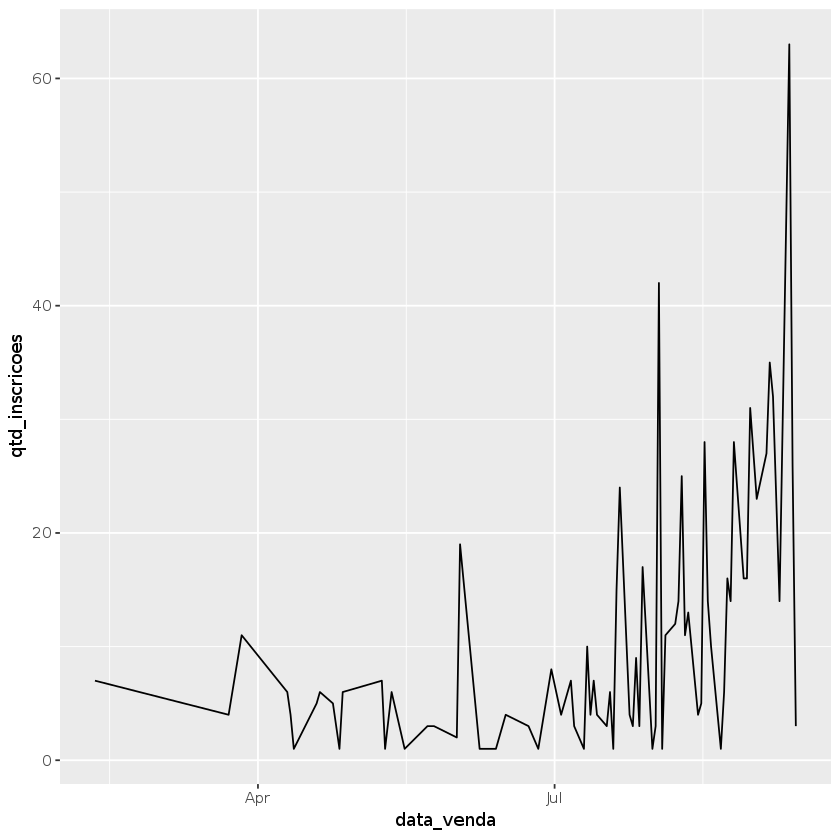

In [8]:
dados_vendas %>% 
    ggplot( aes( x = data_venda, y = qtd_inscricoes ) ) +
    geom_line()

### Verificar estacionariedade

In [9]:
adf.test( x = dados_vendas$qtd_inscricoes, alternative = 'stationary' )


	Augmented Dickey-Fuller Test

data:  dados_vendas$qtd_inscricoes
Dickey-Fuller = -2.1181, Lag order = 4, p-value = 0.5273
alternative hypothesis: stationary


Verificamos que a série não é estacionária.

### Integração - I(d)

Podemos verificar o grau de integração para obter a estacionariedade.

In [10]:
adf.test( x = diff(dados_vendas$qtd_inscricoes, 1), alternative = 'stationary' )

Warning message in adf.test(x = diff(dados_vendas$qtd_inscricoes, 1), alternative = "stationary"):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  diff(dados_vendas$qtd_inscricoes, 1)
Dickey-Fuller = -6.1176, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


Com 1 diferenciação podemos obter a estacionariedade.

O novo gráfico com a série diferenciada.

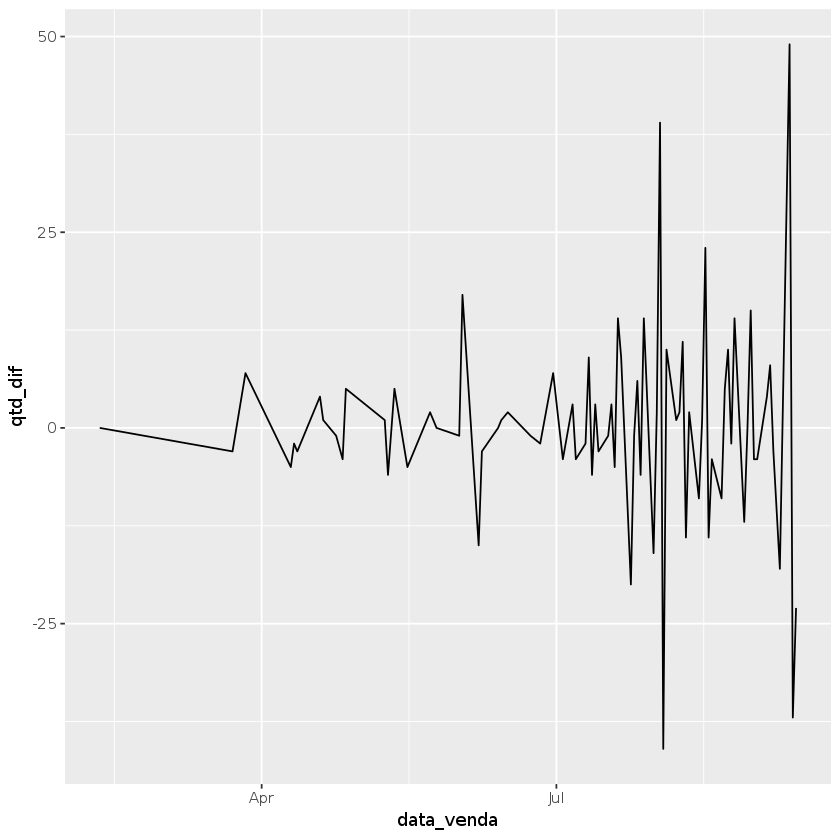

In [11]:
dados_vendas %>% 
    mutate( qtd_dif = c(0,diff(qtd_inscricoes)) ) %>% 
    ggplot( aes( x = data_venda, y = qtd_dif ) ) +
    geom_line()

### Parâmetros AR(p)

Para ter uma idéia de quantos parâmetros AR podem ser necessários verificamos o gráfico PACF.

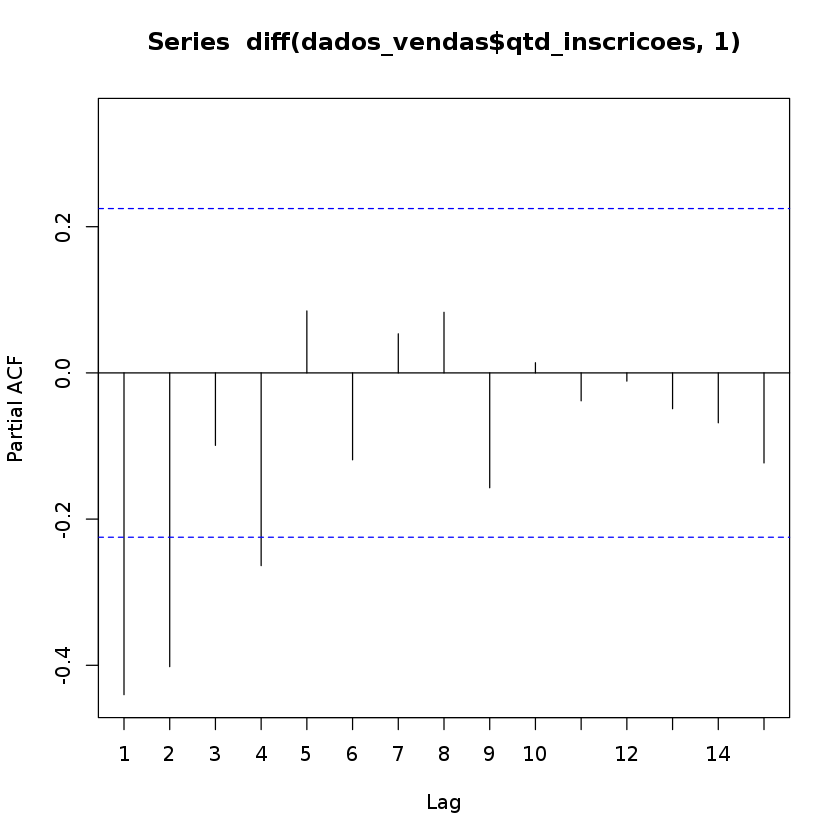

In [12]:
Pacf( x = diff(dados_vendas$qtd_inscricoes, 1), lag.max = 15 )

Observamos 3 lags fora da linha tracejada. Portanto, temos uma idéia que a parte AR terá ordem de até 4 (maior lag foi 4).

### Parâmetros MA(q)

Para ter uma idéia de quantos parâmetros AR podem ser necessários verificamos o gráfico ACF.

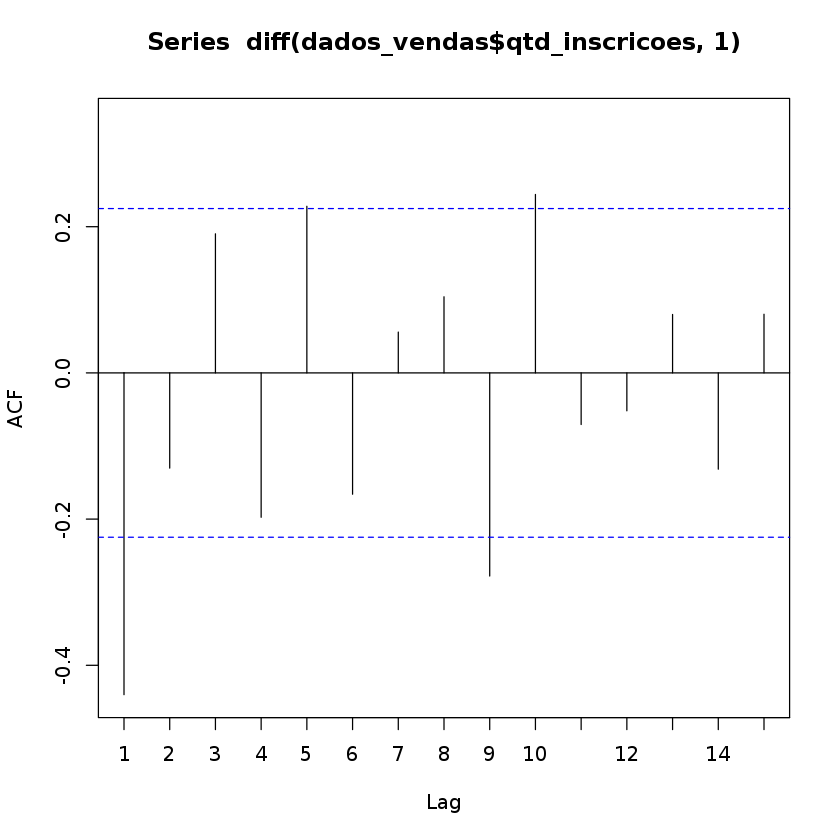

In [13]:
Acf( x = diff(dados_vendas$qtd_inscricoes, 1), lag.max = 15 )

Observamos 3 lags fora da linha tracejada. Portanto, temos uma idéia que a parte MA terá ordem de até 10 (ultimo lag foi 10). 

Porém, durante o diagnóstico do modelo, perceberemos que não será necessária a ordem 10.

### Estimação do modelo ARIMA(p,d,q)

Observamos que a integração é de ordem d = 1, p até 4 e q até 10.

Iremos testar vários modelos.

### Amostras de treino e teste

Em séries temporais não podemos dividir aleatoriamente as amostras. Devemos selecionar um passado e buscar prever o futuro.

In [14]:
dados_vendas %>% dim

[1] 77  4

In [22]:
dados_vendas_train <- dados_vendas %>% slice(1:72)
dados_vendas_test <- dados_vendas %>% slice(73:77)

#### Modelo ARIMA(4, 1, 0)

In [23]:
modelo_4_1_0 <- Arima( dados_vendas_train$qtd_inscricoes, order = c(4, 1, 0 ) )
modelo_4_1_0

Series: dados_vendas_train$qtd_inscricoes 
ARIMA(4,1,0) 

Coefficients:
          ar1     ar2      ar3      ar4
      -0.7953  -0.768  -0.4839  -0.4708
s.e.   0.1037   0.128   0.1265   0.1009

sigma^2 estimated as 53.35:  log likelihood=-240.72
AIC=491.44   AICc=492.37   BIC=502.76

Podemos diagnosticar a qualidade do modelo analisando o ACF e PACF dos resíduos do modelo.

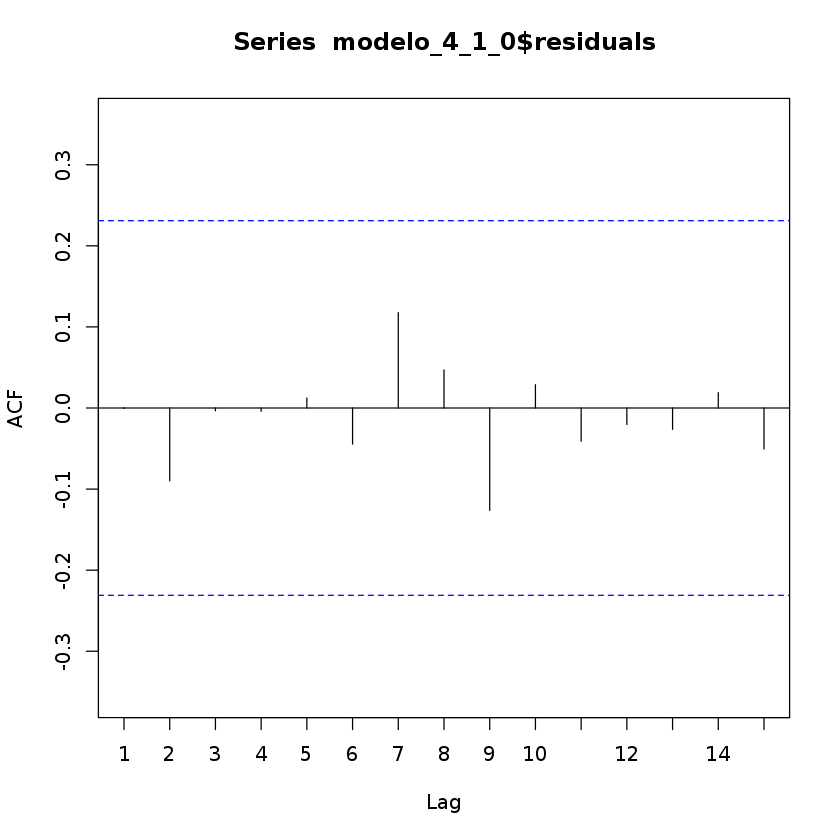

In [24]:
Acf( modelo_4_1_0$residuals, lag.max = 15 )

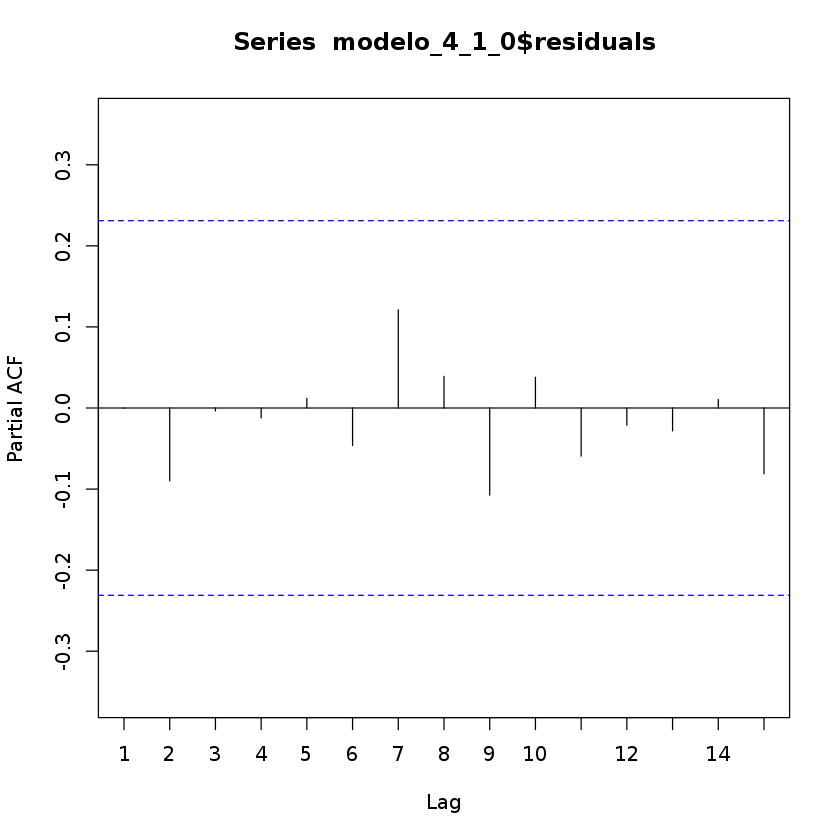

In [25]:
Pacf( modelo_4_1_0$residuals, lag.max = 15 )

Por meio dos gráficos, observamos que não há algum lag fora das linhas tracejadas.

Este resultado nos mostra que o modelo não possui problema de autocorrelação e também pode não ser necessário utilizar os lags da parte MA.

### Avaliação do modelo

In [29]:
dados_vendas_test %<>% 
  mutate( modelo_4_1_0_pred = forecast( modelo_4_1_0, h = 5)$mean )

dados_vendas_test

data_venda,data_evento,qtd_inscricoes,ticket,pub_pred_m1,modelo_4_1_0_pred
2017-09-06,2017-09-13,32,2164.585,29.38437,29.38437
2017-09-08,2017-09-13,14,671.000,27.65382,27.65382
2017-09-11,2017-09-13,63,1005.734,27.58884,27.58884
2017-09-12,2017-09-13,26,2036.800,27.92030,27.92030
2017-09-13,2017-09-13,3,300.000,31.18797,31.18797


Podemos verificar a qualidade das previsões.

In [30]:
accuracy( dados_vendas_test$modelo_4_1_0_pred,
          dados_vendas_test$qtd_inscricoes )

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.147061,21.19183,16.35778,-196.026,221.7788


Podemos testar diversos outros modelos.

Pelo momento, somente iremos testar mais um. Iremos incluir a variável ticket.

In [31]:
modelo_4_1_0_x <- Arima(dados_vendas_train$qtd_inscricoes, 
                        order = c(4, 1, 0 ),
                        xreg =  dados_vendas_train %>% select( ticket ) )
modelo_4_1_0_x

Series: dados_vendas_train$qtd_inscricoes 
Regression with ARIMA(4,1,0) errors 

Coefficients:
          ar1      ar2      ar3      ar4   ticket
      -0.8349  -0.7618  -0.5101  -0.4727  -0.0021
s.e.   0.1050   0.1303   0.1289   0.1009   0.0011

sigma^2 estimated as 51.57:  log likelihood=-239
AIC=489.99   AICc=491.3   BIC=503.57

Será que melhor na amostra de teste?

In [33]:
dados_vendas_test %<>% 
  mutate( modelo_4_1_0_x_pred = forecast( modelo_4_1_0_x, xreg = dados_vendas_test %>% select( ticket ), h = 5)$mean )
dados_vendas_test

data_venda,data_evento,qtd_inscricoes,ticket,pub_pred_m1,modelo_4_1_0_pred,modelo_4_1_0_x_pred
2017-09-06,2017-09-13,32,2164.585,29.38437,29.38437,27.23548
2017-09-08,2017-09-13,14,671.000,27.65382,27.65382,29.02961
2017-09-11,2017-09-13,63,1005.734,27.58884,27.58884,27.94507
2017-09-12,2017-09-13,26,2036.800,27.92030,27.92030,26.22338
2017-09-13,2017-09-13,3,300.000,31.18797,31.18797,33.23126


In [34]:
accuracy( dados_vendas_test$modelo_4_1_0_x_pred,
          dados_vendas_test$qtd_inscricoes )

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.132958,21.86969,17.06074,-209.0781,237.2908


Podemos ainda testar as variaveis: "número de dias até o evento" e criar uma variável que indica "período distante" e "período próximo". Quais outros testes você faria?